In [1]:
#1) Do PCA of existing features to remove correlations, then try bagging and RF and optimize
#2) Do PCA clustering by atom type as well?
#3) Extend features I've gotten from distance calculations?

In [120]:
import os
import numpy as np 
import pandas as pd 

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

import sklearn.metrics as metrics
from sklearn.metrics.scorer import make_scorer

from sklearn.linear_model import LinearRegression

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import itertools
from scipy import linalg

from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

import networkx as nx

init_notebook_mode(connected=True)

# Functions

In [121]:
def mean_squared_0floor_log_error(ground_truth, predictions):
    predictions[predictions < 0] = 0
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return np.average(diff)

In [122]:
def mean_squared_log_error_JT(ground_truth, predictions):
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return np.sqrt(np.average(diff))

In [123]:
print(os.getcwd())
#print(os.listdir('data/train'))

C:\Users\Jonathan\Documents\Python Scripts\Kaggle\Nomad - TCO


## Load Data

In [124]:
dfTrain = pd.read_csv("data/train.csv")
dfTest = pd.read_csv("data/test.csv")
smplSub = pd.read_csv("sample_submission.csv")
assert(all(dfTrain.isnull().sum()) == False) # report if any missing data
assert(all(dfTest.isnull().sum()) == False) # report if any missing data

In [125]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


## Feature Creation

In [126]:
def LoadGeometries(folderPath):
    '''
    Function to read in geometry of each material, calculistLate necessary properties, and merge with original df to use as features
    Depends on following functions: LoadGeometry
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = CalcGeometryFeatures(folderPath, folder)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [127]:
def LoadGeomPCAFeatures(folderPath):
    '''
    Function to read in geometry of each material, calculate PCA features, and create df that can be merged later
    with other feature df (e.g. LoadGeometries df)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = GeometryPCA(folderPath, folder, plotFlag=False)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [128]:
def GeometryPCA(folderPath, folder, plotFlag=False):
    '''
    Reads one geometry and calculates PCA transformation and plots 2d comparisons of axes
    Returns PCA coordinates
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
    #Plot PCA analysis of coordinates
    pca, volume = PCAplot(dfAtom, plotFlag)

    #Feature: Add volume to feature list
    dfMat['Hull Volume'] = volume[0]
    dfMat['Hull Volume 1-2'] = volume[1]
    dfMat['Hull Volume 1-3'] = volume[2]
    dfMat['Hull Volume 2-3'] = volume[3]
    dfMat['Hull Volume Per Atom'] = volume[0] / len(dfAtom)
    dfMat['Hull Volume 1-2 Per Atom'] = volume[1] / len(dfAtom)
    dfMat['Hull Volume 1-3 Per Atom'] = volume[2] / len(dfAtom)
    dfMat['Hull Volume 2-3 Per Atom'] = volume[3] / len(dfAtom)
    
    #Feature: Count number of unique coordinate values along each PCA axis
    dfMat['Unique 1'] = len(set(np.round(pca,2)['1st']))
    dfMat['Unique 2'] = len(set(np.round(pca,2)['2nd']))
    dfMat['Unique 3'] = len(set(np.round(pca,2)['3rd']))
    
    #Feature: Calculate cluster features
    dfMat = CalcPCAClusterFeatures(dfMat, pca, ['1st', '2nd', '3rd'])
    
    return dfMat

In [129]:
def CalcPCAClusterFeatures(inDfMat, inDfPCA, colPCA):
    '''
    Calculates multiple features from PCA data using PCA coordinate matrix as input
    Use GMM to find cluster number with full covariance for elongated shapes.
    Input:
    1) InDfPCA: df with 3 PCA directions (1st, 2nd, 3rd column names)
    '''

    #Count number of clusters and clusters per atom in 3D
    bic3D = []
    for k in range(1,len(inDfPCA)):
        gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                              init_params = 'kmeans', max_iter=300)
        gmm.fit(inDfPCA)
        gmm.predict(inDfPCA)
        bic3D.append(gmm.bic(inDfPCA))
    inDfMat['Clusters'] = np.argmin(bic3D)
    inDfMat['Clusters Per Atom'] = np.argmin(bic3D) / len(inDfPCA)
    
    #Count number of clusters and clusters per atom in each PCA direction
    listCluster = []
    for i in range(0,2):
        for j in range(i+1,3):
            dfInput = inDfPCA[[colPCA[i], colPCA[j]]] #set to current 2 PCA coordinate lists
            bic = [] #initialize list of bic scores
            
            #GMM loop over cluster number to find minimal bic score
            for k in range(1,len(dfInput)):
                gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
                gmm.fit(dfInput)
                gmm.predict(dfInput)
                bic.append(gmm.bic(dfInput))
            
            #Append cluster number with minium bic score, then do final GMM with that number
            #--CAN USE LATER FOR COVARIANCES AS FEATURES!
            listCluster.append(np.argmin(bic)+1)
            gmmFinal = GaussianMixture(n_components = (np.argmin(bic)+1), covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
            gmmFinal.fit(dfInput)
    
    inDfMat['Clusters 1-2'] = listCluster[0]
    inDfMat['Clusters 1-3'] = listCluster[1]
    inDfMat['Clusters 2-3'] = listCluster[2]
    inDfMat['Clusters 1-2 Per Atom'] = listCluster[0] / len(dfInput)
    inDfMat['Clusters 1-3 Per Atom'] = listCluster[1] / len(dfInput)
    inDfMat['Clusters 2-3 Per Atom'] = listCluster[2] / len(dfInput)
    
    return inDfMat

In [130]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

#USAGE EXAMPLE
#X = np.asfarray(dfInput)
#gm = GaussianMixture(n_components = 11, covariance_type = 'full', max_iter=300)
#gm.fit(X)
#color_iter = itertools.cycle(['navy', 'blue', 'cornflowerblue', 'gold',
#                              'darkorange', 'orange'])
#plot_results(X, gm.predict(X), gm.means_, gm.covariances_, 1,
#             'GM')

In [131]:
def PCAplot(geom, plotFlag=False):
    '''
    Calculates PCA transformation of one geometry and returns coordinates and hull volumes
    '''
    #save coordinates and atomType (used for color)
    coord = geom[['x', 'y', 'z']]
    atomType = [str(i) for i in geom['atom']]
    dictColor = {'Al':'green', 'Ga':'red', 'In':'blue', 'O':'black'}
    
    #PCA transformation into matrix output for plotting
    coordPCA = PCA(n_components = 3).fit(coord).transform(coord)
    dfPCA = pd.DataFrame(coordPCA, columns = ['1st', '2nd', '3rd'])
    
    #Calculate values associated with PCA
    #Hull values
    h123 = ConvexHull(dfPCA.iloc[:][['1st', '2nd', '3rd']])
    vol123 = h123.volume
    h12 = ConvexHull(dfPCA.iloc[:][['1st', '2nd']])
    vol12 = h12.volume
    h13 = ConvexHull(dfPCA.iloc[:][['1st', '3rd']])
    vol13 = h13.volume
    h23 = ConvexHull(dfPCA.iloc[:][['2nd', '3rd']])
    vol23 = h23.volume
    
    #Plot coordinates with colored atoms and 1st 2 dimensions of PCA
    if plotFlag==True:
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.scatter(coord[['x']], coord[['y']], coord[['z']], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        ax2 = fig.add_subplot(222)
        ax2.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['2nd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax2.plot(dfPCA.loc[h12.vertices]['1st'], dfPCA.loc[h12.vertices]['2nd'], 'r-', lw=1)
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')

        ax3 = fig.add_subplot(223)
        ax3.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax3.plot(dfPCA.loc[h13.vertices]['1st'], dfPCA.loc[h13.vertices]['3rd'], 'r-', lw=1)
        ax3.set_xlabel('1st component')
        ax3.set_ylabel('3rd component')

        ax4 = fig.add_subplot(224)
        ax4.scatter(dfPCA.iloc[:]['2nd'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax4.plot(dfPCA.loc[h23.vertices]['2nd'], dfPCA.loc[h23.vertices]['3rd'], 'r-', lw=1)
        ax4.set_xlabel('2nd component')
        ax4.set_ylabel('3rd component')
    
    return dfPCA, [vol123, vol12, vol13, vol23]

In [226]:
def CalcGeometryFeatures(folderPath, folder):
    '''
    Reads one geometry and calculates all necessary features
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id', 'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
        # Save lattice vector information to dfMat
        dfMat = AddLattice(dfMat, colMatFeat, lat)
        
        #Calculate distances between all atoms using PBC's
        dfAtom = CalcDistances(dfAtom, lat, nndist1=1.2)
        
        # Bond lengths, NN distances, and coordination numbers
        #--For each atom type
        for atom in ['O', 'Ga', 'Al', 'In']:
            if len(dfAtom[dfAtom['atom'] == atom]) > 0:
                dfMat[atom + ' CN Avg'] = dfAtom.groupby('atom').mean().at[atom,'CN']
                dfMat[atom + ' CN Min'] = dfAtom.groupby('atom').min().at[atom,'CN']
                dfMat[atom + ' CN Max'] = dfAtom.groupby('atom').max().at[atom,'CN']
                dfMat[atom + '-O NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'O NN1 BL']
                dfMat[atom + '-Ga NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Al NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Al NN1 BL']
                dfMat[atom + '-In NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'In NN1 BL']
            
        # Bond angle
    
    return dfAtom, dfMat

In [133]:
def CalcDistances(df, lat, nndist1=1.2):
    '''
    1) Calculates bond lengths for 1st and 2nd nearest neighbors for each atom type
    2) Calculates coordination number of each atom
    '''
    # Create columns:
    df['CN'] = np.nan #coordination number
    df['O NN1 BL'] = np.nan #average bond length of closest atom
    df['O NN1 Count'] = 0 #closest atom coordination number
    df['Ga NN1 BL'] = np.nan #average bond length of closest atom
    df['Ga NN1 Count'] = 0 #closest atom coordination number
    df['Al NN1 BL'] = np.nan #average bond length of closest atom
    df['Al NN1 Count'] = 0 #closest atom coordination number
    df['In NN1 BL'] = np.nan #average bond length of closest atom
    df['In NN1 Count'] = 0 #closest atom coordination number
    
    #Create reciprocal lattice vectors
    lat_r = np.linalg.inv(lat)
    
    # Cycle through each atom and calculate distance to all others
    for ind1 in df.index:
        tmpDist = [] #temporary list of distances
        tmpAtom = [] #temporary list of atom corresponding to each distance
        v1 = np.asfarray(df.iloc[ind1]['x':'z'])
        #v1_r = np.matmul(lat_r, v1) #represent v1 in recip. space
        # Loop over every other atom
        for ind2 in df.index:
            if ind1 != ind2:
                v2 = np.asfarray(df.iloc[ind2]['x':'z']) #other coordinates as np array
                #v2_r = np.matmul(lat_r, v2) #represent v2 in recip. space
                dist = DistancePBCreal(v1, v2, lat)
                tmpDist.append(dist) #distance list for one atom
                tmpAtom.append(df.at[ind2, 'atom']) #atoms at each distance
        tmpDf = pd.DataFrame(columns=['distance', 'atom'])
        tmpDf['distance'] = tmpDist
        tmpDf['atom'] = tmpAtom
        tmpDf = tmpDf.sort_values(by = ['distance'])
        
        #Calculate coordination number
        tmpCN = tmpDf[(tmpDf['distance'] >= min(tmpDf['distance'])) & (tmpDf['distance'] < nndist1*min(tmpDf['distance']))]
        df.at[ind1, 'CN'] = len(tmpCN.index)
        
        # Calculate all nn quantities for current atom BY ATOM TYPE
        # -Oxygen
        df = CalcNNCoordBondLength(df, tmpDf, 'O', 'O NN1 BL', 'O NN1 Count', ind1, nndist1)
        # -Gallium
        df = CalcNNCoordBondLength(df, tmpDf, 'Ga', 'Ga NN1 BL', 'Ga NN1 Count', ind1, nndist1)
        # -Aluminum
        df = CalcNNCoordBondLength(df, tmpDf, 'Al', 'Al NN1 BL', 'Al NN1 Count', ind1, nndist1)
        # -Indium
        df = CalcNNCoordBondLength(df, tmpDf, 'In', 'In NN1 BL', 'In NN1 Count', ind1, nndist1)
          
    return df

In [134]:
def CalcNNCoordBondLength(dfAtom, dfDist, atomType, col1, col2, index, nndist1):
    '''
    Function that takes distances as input to calculate 1) nearest neighbor distnaces,
    2) coordination numbers, 3) bond lengths for a given atom type (string)
    '''
    tmp = dfDist[dfDist['atom'] == atomType]
    if len(tmp) > 0:
        tmp1stNN = tmp[(tmp['distance'] >= min(tmp['distance'])) & (tmp['distance'] < nndist1*min(tmp['distance']))]
        dfAtom.at[index, col1] = np.average(tmp1stNN['distance'])
        dfAtom.at[index, col2] = len(tmp1stNN.index)
    
    return dfAtom

In [135]:
def AddLattice(df, cols, listLat):
    '''
    Adds lattice vector information to input df
    Used in following functions: CalcGeometryFeatures
    '''
    if 'xx' in cols:
        df['xx'] = listLat[0][0]
    if 'xy' in cols:
        df['xy'] = listLat[0][1]
    if 'xz' in cols:
        df['xz'] = listLat[0][2]
    if 'yx' in cols:
        df['yx'] = listLat[1][0]
    if 'yy' in cols:
        df['yy'] = listLat[1][1]
    if 'yz' in cols:
        df['yz'] = listLat[1][2]
    if 'zx' in cols:
        df['zx'] = listLat[2][0]
    if 'zy' in cols:
        df['zy'] = listLat[2][1]
    if 'zz' in cols:
        df['zz'] = listLat[2][2]    
    
    return df

In [136]:
def DistancePBCreal(v1, v2, lattice):
    '''
    Function to calculate distance, checking PBC, usingn real
    lattice vectors
    v1 - first vector in real space
    v2 - second vector in real space
    lattice - 3x3 lattice vectors
    '''
    lat = np.asfarray(lattice)
    
    dMin = np.inf
    
    for l in range(-1,2):
        for m in range(-1,2):
            for n in range(-1,2):
                v2_shift = v2 + l * lat[0] + m*lat[1] + n*lat[2]
                diff = abs(v2_shift - v1)
                d = np.linalg.norm(diff)
                if d < dMin:
                    dMin = d
    return dMin

In [137]:
def DistancePBCrecip(v1r, v2r, lattice):
    '''
    Function to calculate distance between two points, checking
    periodic boundary conditions for shortest distance
    Input:
    v1r - first vector in reciprocal space
    v2r - second vector in reciprocal space
    lattice- 3x3 matrix of lattice vectors (xx to zz)
    '''  
    vDiff_r = []
    
    for i, (a, b) in enumerate(zip(v1r, v2r)):
        diff = b - a
        if diff > 0.5: #check if over half the reduced lattice vector length away
            b = b-1
            diff = abs(b-a)
        if diff < -0.5:
            b = b+1
            diff = abs(b-a)
        vDiff_r.append(diff) #create difference vector in recip space
    return np.linalg.norm(np.matmul(lattice, vDiff_r)) #return distance of transformed difference

In [227]:
atom1, mat1 = CalcGeometryFeatures('data/train', '1')

In [239]:
pcaTest = PCA(n_components=10)
forT = atom1[atom1['atom'] == 'Ga'].T.loc[['x', 'y', 'z']]
pcaTest.fit_transform(forT)

array([[ -6.91979097e+00,  -4.51542212e+00,   1.59319104e-15],
       [ -1.53629191e+00,   6.94815420e+00,   1.59319104e-15],
       [  8.45608289e+00,  -2.43273208e+00,   1.59319104e-15]])

In [237]:
forT

,0,3,4,9,10,13,15,16,18,20,24,29
x,1.60889,8.4118,0.95588,5.89328,4.11494,6.59554,8.42036,0.868794,4.19496,1.6892,3.43982,9.06709
y,7.27642,1.23615,2.99893,5.59882,2.90994,1.32471,7.17009,0.262223,8.27981,4.5291,1.33396,5.57802
z,6.38316,1.77728,1.80135,-0.0267041,4.57123,4.56432,9.14032,9.16506,4.55588,4.56874,7.20928,2.59621


In [138]:
# Load all training geometries and create new features from them using distances
#dfTrainNewFeat = LoadGeometries('data/train')

In [139]:
# Load all testing geometries and create new features from them using distances
#dfTestNewFeat = LoadGeometries('data/test')

In [140]:
#--Save Feature Data to csv to later load
#dfTrainNewFeat.to_csv('train_new_feat_1_11_18.csv')

In [141]:
#--Save Test Feature Data to csv to later load
#dfTestNewFeat.to_csv('test_new_feat_1_11_18.csv')

In [142]:
#--Load Feature Data to prevent taking the time to recompute them
dfTrainNewFeat = pd.read_csv('train_new_feat_1_11_18.csv', index_col = 0)
dfTestNewFeat = pd.read_csv('test_new_feat_1_11_18.csv', index_col = 0)

In [143]:
# Load training geometries and calculate PCA clusters/features of geometry
#dfTrainPCAFeat = LoadGeomPCAFeatures('data/train')

In [144]:
# Load test geometries and calculate PCA clusters/features of geometry
#dfTestPCAFeat = LoadGeomPCAFeatures('data/test')

In [145]:
# Save PCA features to csv to load later
#dfTrainPCAFeat.to_csv('train_pca_feat_1_10_2018.csv')

In [146]:
# Save PCA features to csv to load later
#dfTestPCAFeat.to_csv('test_pca_feat_1_10_2018.csv')

In [147]:
#--Load feature data to prevent taking the time to recompute them
dfTrainPCAFeat = pd.read_csv('train_pca_feat_1_10_2018.csv', index_col = 0)
dfTestPCAFeat = pd.read_csv('test_pca_feat_1_10_2018.csv', index_col = 0)

In [148]:
#Merge distance features with original df
dfTrain = dfTrain.merge(dfTrainNewFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTestNewFeat, how='inner', on='id')

In [149]:
#Merge PCA features with original df
dfTrain = dfTrain.merge(dfTrainPCAFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTrainPCAFeat, how='inner', on='id')

## Additional Feature Generation

In [150]:
#Number of each atom
dfTrain['Al Atoms'] = dfTrain['percent_atom_al'] * dfTrain['number_of_total_atoms']
dfTrain['Ga Atoms'] = dfTrain['percent_atom_ga'] * dfTrain['number_of_total_atoms']
dfTrain['In Atoms'] = dfTrain['percent_atom_in'] * dfTrain['number_of_total_atoms']
dfTest['Al Atoms'] = dfTest['percent_atom_al'] * dfTest['number_of_total_atoms']
dfTest['Ga Atoms'] = dfTest['percent_atom_ga'] * dfTest['number_of_total_atoms']
dfTest['In Atoms'] = dfTest['percent_atom_in'] * dfTest['number_of_total_atoms']

In [151]:
#Make generic cation-O bond lengths
dfTrain['Cation-O NN1 BL Avg'] = dfTrain[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Min'] = dfTrain[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Max'] = dfTrain[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Avg'] = dfTest[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Min'] = dfTest[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Max'] = dfTest[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)

In [152]:
#Calculate ranges of NN1 bond lengths
for atom1 in ['Al', 'Ga', 'In', 'O']:
    for atom2 in ['Al', 'Ga', 'In', 'O']:
        colNew = atom1+'-'+atom2+' NN1 BL Range'
        colMax = atom1+'-'+atom2+' NN1 BL Max'
        colMin = atom1+'-'+atom2+' NN1 BL Min'
        dfTrain[colNew] = dfTrain[colMax] - dfTrain[colMin]
        dfTest[colNew] = dfTest[colMax] - dfTest[colMin]

In [153]:
#Calculate inverse bond lengths 
for atom1 in ['Al', 'Ga', 'In', 'O']:
    for atom2 in ['Al', 'Ga', 'In', 'O']:
        colNewAvg = atom1+'-'+atom2+' NN1 BL Avg Inv'
        colNewMax = atom1+'-'+atom2+' NN1 BL Max Inv'
        colNewMin = atom1+'-'+atom2+' NN1 BL Min Inv'
        colNewRange = atom1+'-'+atom2+' NN1 BL Range Inv'
        colAvg = atom1+'-'+atom2+' NN1 BL Avg'
        colMax = atom1+'-'+atom2+' NN1 BL Max'
        colMin = atom1+'-'+atom2+' NN1 BL Min'
        colRange = atom1+'-'+atom2+' NN1 BL Range'
        
        dfTrain[colNewAvg] = 1/dfTrain[colAvg]
        dfTrain[colNewMax] = 1/dfTrain[colMax]
        dfTrain[colNewMin] = 1/dfTrain[colMin]
        dfTrain[colNewRange] = 1/dfTrain[colRange]
        
        dfTest[colNewAvg] = 1/dfTest[colAvg]
        dfTest[colNewMax] = 1/dfTest[colMax]
        dfTest[colNewMin] = 1/dfTest[colMin]
        dfTest[colNewRange] = 1/dfTest[colRange]

## Missing Data Resolution

Currently, missing data arises from that atom not being present in given material, so no bond distances or coordinations can be created.  Solution right now is to set this to 0 for inverse bond lengths and coordination, as this indicates that there is no coordination.  Then remove any columns with NaN.

In [155]:
#Fill in inverse bond lengths with 0 b/c consistent with relationship
sub = 'Inv'
colInv = [s for s in dfTrain.columns if sub.lower() in s.lower()]
dfTrain[colInv] = dfTrain[colInv].fillna(0)
dfTest[colInv] = dfTest[colInv].fillna(0)

In [156]:
#Fill in CN avg and std NaN with 0
colCN = ['Al CN Avg', 'Al CN Min', 'Al CN Max', 'Ga CN Avg', 'Ga CN Min', 'Ga CN Max', 'In CN Avg', 'In CN Min', 'In CN Max']
dfTrain[colCN] = dfTrain[colCN].fillna(0)
dfTest[colCN] = dfTest[colCN].fillna(0)

In [188]:
with pd.option_context('mode.use_inf_as_null', True):
    for atom1 in ['Al', 'Ga', 'In', 'O']:
        for atom2 in ['Al', 'Ga', 'In', 'O']:
            colInf = atom1+'-'+atom2+' NN1 BL Range Inv'
            dfTrain[colInf].replace(np.inf, dfTrain[colInf].max(), inplace=True)
            dfTest[colInf].replace(np.inf, dfTest[colInf].max(), inplace=True)

### DROP NaN

In [158]:
dfTrain = dfTrain.dropna(axis = 1)
dfTest = dfTest.dropna(axis = 1)

In [190]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,O-Ga NN1 BL Min Inv,O-Ga NN1 BL Range Inv,O-In NN1 BL Avg Inv,O-In NN1 BL Max Inv,O-In NN1 BL Min Inv,O-In NN1 BL Range Inv,O-O NN1 BL Avg Inv,O-O NN1 BL Max Inv,O-O NN1 BL Min Inv,O-O NN1 BL Range Inv
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0.561276,0.484784,0.000000,0.000000,0.000000,0.000000,0.350848,0.344755,0.357482,9.683622
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0.560260,0.448011,0.000000,0.000000,0.000000,0.000000,0.356810,0.355782,0.358885,41.144802
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,0.560534,0.401672,0.000000,0.000000,0.000000,0.000000,0.353561,0.351257,0.354353,40.199857
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0.000000,0.000000,0.425256,0.245631,0.516145,0.468668,0.361545,0.361544,0.361546,71119.871181
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0.520004,5.501476,0.392413,0.220676,0.455606,0.427963,0.335174,0.334245,0.337049,40.184682


In [191]:
#Target columns
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']
#Feature columns
features = list(set(list(dfTrain.columns)) - set(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev']))

## Exploratory Data Analysis Using Plotly

### PCA - determine what features to extract from PCA
Ideas: hull volumes, some clustering ratio?  For example, for training data '2', 2nd and 3rd axes show clustering

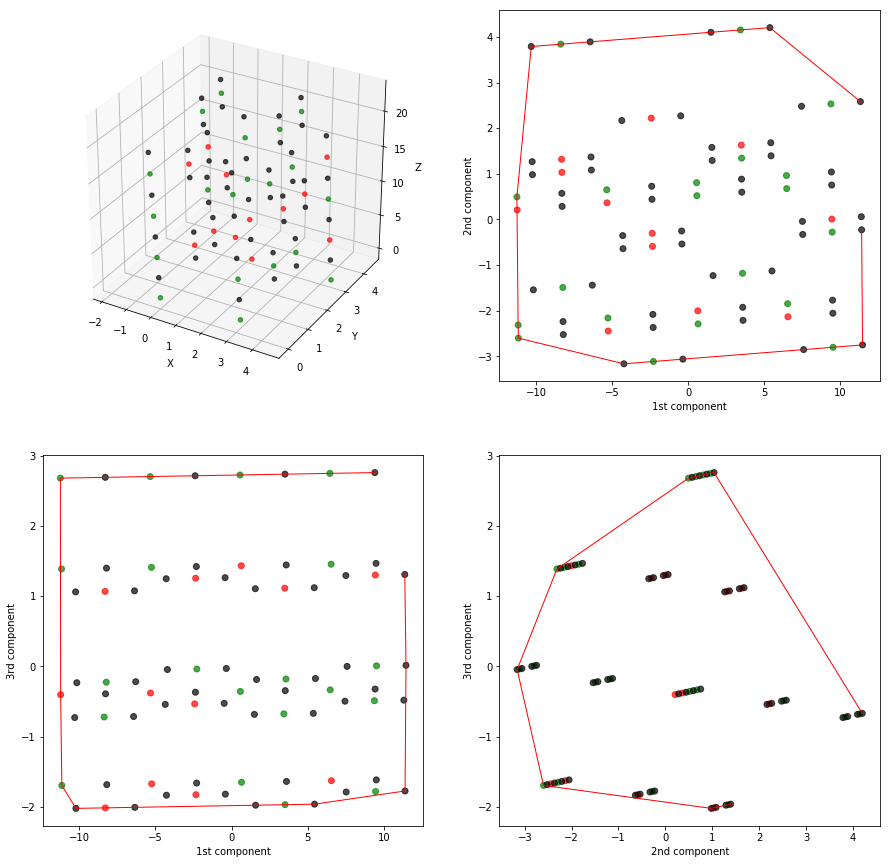

In [35]:
mat1 = GeometryPCA('data/train', '2', plotFlag=True)

### Correlations

In [192]:
corrFeat = dfTrain[features].corr()
dataCorrFeat = [go.Heatmap(x = features, y = features, z = corrFeat.values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Feature Correlation',
             xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              width = 750, height = 750,
              autosize = False
              )
figure = dict(data = dataCorrFeat, layout = layout)
iplot(figure)

Conclusions: <br />
    - lattice_angle_beta_degree highly correlated with lattice_vector_1_ang.  Plot both together and combine as new feature?
    - number of atoms correlated with larger lattice vectors - self-explanatory.
    - space group correlated with larger lattice_vector_3_ang.  Any way to use this?

In [193]:
corrAll = dfTrain[features + targets].corr()
dataCorrAll = [go.Heatmap(x = features, y = targets, z = corrAll.loc[targets, features].values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Target Correlation',
              xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Targets', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              width = 800, height = 250,
              autosize = False
              )
figure = dict(data = dataCorrAll, layout = layout)
iplot(figure)

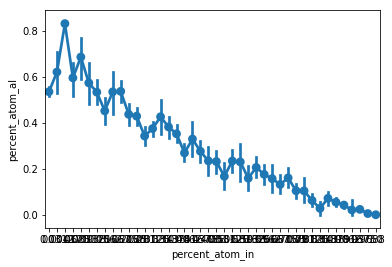

In [194]:
sns.pointplot(dfTrain['percent_atom_in'], dfTrain['percent_atom_al'])

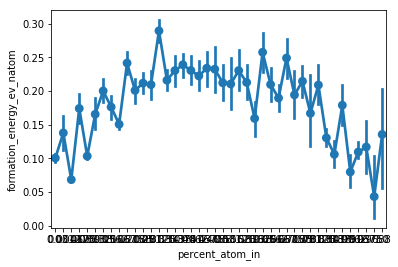

In [195]:
sns.pointplot(dfTrain['percent_atom_in'], dfTrain['formation_energy_ev_natom'])

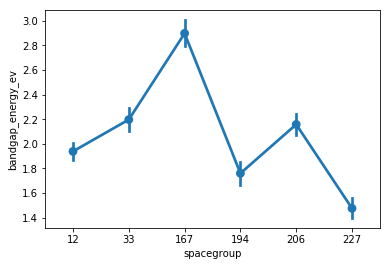

In [165]:
sns.pointplot(dfTrain['spacegroup'], dfTrain['bandgap_energy_ev'])

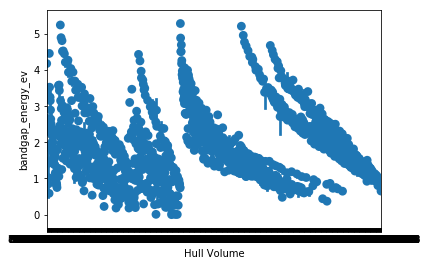

In [196]:
sns.pointplot(dfTrain['Hull Volume'], dfTrain['bandgap_energy_ev'], linestyles='')

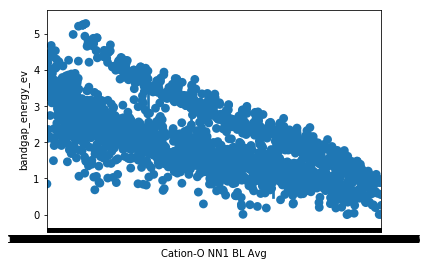

In [197]:
sns.pointplot(dfTrain['Cation-O NN1 BL Avg'], dfTrain['bandgap_energy_ev'], linestyles='')

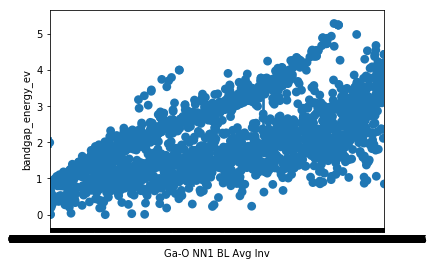

In [199]:
sns.pointplot(dfTrain['Ga-O NN1 BL Avg Inv'], dfTrain['bandgap_energy_ev'], linestyles='')

Ga-O NN1 BL Avg and Cation in general shows two clusters of relationships - need to separate somehow

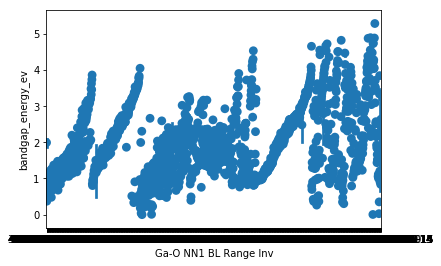

In [198]:
sns.pointplot(dfTrain['Ga-O NN1 BL Range Inv'], dfTrain['bandgap_energy_ev'], linestyles='')

Conclusions: <br />
    - bandgap_energy_ev: most correlated to lower percent_atom_in and higher percent_atom_al - use both in initial model.  Should test polynomial features to get right degree.
    - formation_energy_ev_natom: not as highly correlated, but related to lattice_vector_3, percent_atom_ga, spacegroup
    - Hull Volume has interesting periodic relationship with band_gap_ev

## Training and Testing Choice and Scaling and PCA

In [172]:
#features

In [200]:
#--Set features to use
modelFeatures = features
train = dfTrain[modelFeatures]
test = dfTest[modelFeatures]
target = dfTrain[targets]

In [201]:
#--Scale features
scalerStd = StandardScaler(with_mean=True, with_std=True)
scalerMM = MinMaxScaler(feature_range=(0,1))
#Apply scalers to train/test features and targets
trainStd = scalerStd.fit_transform(train)
trainMM = scalerMM.fit_transform(train)
targetStd = scalerStd.fit_transform(target)
targetMM = scalerMM.fit_transform(target)
testStd = scalerStd.fit_transform(test)
testMM = scalerMM.fit_transform(test)

In [202]:
#--PCA to uncorrelate features
trainStdPCA = PCA().fit_transform(trainStd)
trainMMPCA = PCA().fit_transform(trainMM)
testStdPCA = PCA().fit_transform(testStd)
testMMPCA = PCA().fit_transform(testMM)

### Linear Regression

This is just a starting point to see what error we get with a basic polynomial regression and few features

In [203]:
#--Cross-Validation to determine optimal polynomial - should use GridSearchCV next to use differen poly for each var
linFeatures = ['percent_atom_al', 'percent_atom_in', 'percent_atom_ga',
               'spacegroup',
               'lattice_vector_3_ang']
polys = 3
print("CV Results:")
print("-----------")
for poly in range(0,polys+1):
    # Create polynomial features
    pf = PolynomialFeatures(degree = poly)
    train_pf = pf.fit_transform(train[linFeatures])
    
    # Create linear regression object
    lr = LinearRegression(normalize = False)
    
    # Set up shuffle split for cross validation
    ss = ShuffleSplit(n_splits = 10, test_size = 0.20)
    
    # Perform cross-validation - take sqrt of MSLE for RMSLE as indicated in competition
    cvBG0 = np.sqrt(cross_val_score(lr, train_pf, target['bandgap_energy_ev'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    cvFE0 = np.sqrt(cross_val_score(lr, train_pf, target['formation_energy_ev_natom'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    avgBG0 = np.average(cvBG0)
    avgFE0 = np.average(cvFE0)
    avgFinal0 = 0.5 * (avgBG0 + avgFE0)

    print("Poly = %.0i, BG RMSLE = %.3f, FE RMSLE = %.3f, Final RMSLE = %.3f" % (poly, avgBG0, avgFE0, avgFinal0))    

CV Results:
-----------
Poly = 0, BG RMSLE = 0.338, FE RMSLE = 0.087, Final RMSLE = 0.212
Poly = 1, BG RMSLE = 0.191, FE RMSLE = 0.071, Final RMSLE = 0.131
Poly = 2, BG RMSLE = 0.101, FE RMSLE = 0.043, Final RMSLE = 0.072
Poly = 3, BG RMSLE = 0.091, FE RMSLE = 0.038, Final RMSLE = 0.064


Conclusions: <br />
    - key variables to include are: percents of all atoms except Ga that doesn't matter (helps BG), percentGa and spacegroup and z-d listLattice vector (helps FE)
    - 3rd degree polynomial enough

In [229]:
#--LR: Final fitting and prediction

pf = PolynomialFeatures(degree = 3)
train_pf = pf.fit_transform(train)
test_pf = pf.fit_transform(dfTest[modelFeatures])
lr = LinearRegression(normalize = False)

# BG fitting and prediction
lr.fit(train_pf, target['bandgap_energy_ev'])
predBG = lr.predict(test_pf)

# FE fitting and prediction
lr.fit(train_pf, target['formation_energy_ev_natom'])
predFE = lr.predict(test_pf)

In [230]:
#--LR: Create submission and save to csv
dfSubmit = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmit['formation_energy_ev_natom'] = predFE
dfSubmit['bandgap_energy_ev'] = predBG
dfSubmit.to_csv('lr_nomad_12272017.csv')

## SVM

Turns out that using higher C values, even if giving better test scores in GridSearch, still lead to overfitting and high variance when submitting to Kaggle!  C = 1 seems to be best so far - not sure I understand why!!
All Feature Notes: <br />
    - Set CN NaN values to 0, remove rest - this makes sense physically, as 0 has meaning (no coordination)
        - tranStd optimal: BG=0.088 for C = 1, eps = 0.01, 0.015 training discrepancy;
                           FE = 0.028 for C = 1, eps = 0.01
        - tranMM optimal: BG = 0.082 for C = 100, eps = 0.01
                           FE = 0.028 for C = 100, eps = 0.01
        
    - When including NaN = 0 and all features: much bigger difference between training and test scores - training are awesome!  Lots of variance b/c test scores higher
        - Need to figure out reason for overfitting - would a boost help?
        - With NaN = 0, BG testing scores much worse (much more variance) , not helped by Bagging, so need to use NaN removed for now
    - When excluding NaN and using all features:
        - trainStd optimal :kernel = rbf, C = 1, eps = 0.01 has gotten FE down to 0.031 average (better than reg), but BG still around 0.087
        - tranMM optimal: kernel = rbf, C = 1000, eps = 0.01 has gotten FE down to 0.033, BG = 0.085
Next, need to test ensemble methods: bagging (average) and then boosting (adaboost?)

In [204]:
#Set parameter space for GridSearchCV
kernelsBG = ['rbf']
CBG = [1]
epsBG = [0.01]
svrParamBG = {'kernel':kernelsBG, 'C':CBG, 'epsilon':epsBG}
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [205]:
#Band gap SVR GridSearch results
svrBG = SVR()
svrGsBG = GridSearchCV(svrBG, svrParamBG, cv = ss,
                       scoring=metrics.make_scorer(mean_squared_log_error_JT),
                       return_train_score=True)
svrGsBG.fit(trainStd, target['bandgap_energy_ev'])
svrGsBG.cv_results_

{'mean_fit_time': array([ 0.55535033]),
 'mean_score_time': array([ 0.10667756]),
 'mean_test_score': array([ 0.08844734]),
 'mean_train_score': array([ 0.07113967]),
 'param_C': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_epsilon': masked_array(data = [0.01],
              mask = [False],
        fill_value = ?),
 'param_kernel': masked_array(data = ['rbf'],
              mask = [False],
        fill_value = ?),
 'params': [{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.08160829]),
 'split0_train_score': array([ 0.07227276]),
 'split10_test_score': array([ 0.0910809]),
 'split10_train_score': array([ 0.07155023]),
 'split11_test_score': array([ 0.08454277]),
 'split11_train_score': array([ 0.07259129]),
 'split12_test_score': array([ 0.07700275]),
 'split12_train_score': array([ 0.07337447]),
 'split13_test_score': array([ 0.0850948]),
 'split13_train_score': array([ 0.07215902]),

In [206]:
#Set parameter space for GridSearchCV
kernelsFE = ['rbf']
CFE = [1]
epsFE = [0.01]
svrParamFE = {'kernel':kernelsFE, 'C':CFE, 'epsilon':epsFE}
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [207]:
#Formation energy SVR GridSearch results
svrFE = SVR()
svrGsFE = GridSearchCV(svrFE, svrParamFE, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
svrGsFE.fit(trainStd, target['formation_energy_ev_natom'])
svrGsFE.cv_results_

{'mean_fit_time': array([ 0.43239034]),
 'mean_score_time': array([ 0.06612625]),
 'mean_test_score': array([ 0.02986893]),
 'mean_train_score': array([ 0.01867603]),
 'param_C': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_epsilon': masked_array(data = [0.01],
              mask = [False],
        fill_value = ?),
 'param_kernel': masked_array(data = ['rbf'],
              mask = [False],
        fill_value = ?),
 'params': [{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.0302908]),
 'split0_train_score': array([ 0.01801212]),
 'split10_test_score': array([ 0.02589942]),
 'split10_train_score': array([ 0.01941455]),
 'split11_test_score': array([ 0.03161104]),
 'split11_train_score': array([ 0.01785761]),
 'split12_test_score': array([ 0.02613211]),
 'split12_train_score': array([ 0.01957085]),
 'split13_test_score': array([ 0.02985255]),
 'split13_train_score': array([ 0.01876655])

In [114]:
#--SVM: Final fitting and prediction
# BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
svrBG.fit(trainStd, target['bandgap_energy_ev'])
predSvrBG = svrBG.predict(testStd)

# FE fitting and prediction
svrFE = SVR(kernel='rbf', C=1, epsilon=0.01)
svrFE.fit(trainStd, target['formation_energy_ev_natom'])
predSvrFE = svrFE.predict(testStd)

In [117]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predSvrFE
dfSubmitSVR['bandgap_energy_ev'] = predSvrBG
dfSubmitSVR.to_csv('svr_nomad_Std_01062018.csv')

## Bagging Testing

### BaggingRegressor

Best Yet: <br />
    - BG: Bagging doesn't help!
        - 0.088 - BR: n_estimators: 25, max_features = 30, max_samples = 1.0, SVR: C = 1, eps = 0.01
    - FE: try to reduce variance by increasing n_est and decreasing max_samples, max_features, allows for higher C to fit better - bias-variance tradeoff
        - 0.025 - BR: n_estimators: 75, max_features = 30, max_samples = 0.5, SVR: C = 100, eps = 0.01
        - 0.029 - BR: n_estimators: 50, max_features = 40, max_samples = 1.0, SVR: C = 1, eps = 0.01
        - 0.028 - BR: n_estimators = 25, max_features = 30, max_samples = 0.5, SVR: C = 10, eps = 0.01

In [67]:
# With SVR estimator
svr_for_BR = SVR(kernel='rbf', C=1, epsilon=0.01)
BRsvrBG = BaggingRegressor(base_estimator=svr_for_BR, n_estimators = 25, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
ss = ShuffleSplit(n_splits = 10, test_size = 0.20)

In [68]:
numEst = [25]
maxFeat = [0.25]
maxSamp = [0.25]
BRsvrBG_param = {'n_estimators':numEst, 'max_features':maxFeat, 'max_samples':maxSamp}
BRsvrBG_gs = GridSearchCV(BRsvrBG, BRsvrBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
BRsvrBG_gs.fit(trainStd, target['bandgap_energy_ev'])
BRsvrBG_gs.cv_results_

{'mean_fit_time': array([ 0.30282226]),
 'mean_score_time': array([ 0.12011073]),
 'mean_test_score': array([ 0.11559345]),
 'mean_train_score': array([ 0.11449679]),
 'param_max_features': masked_array(data = [0.25],
              mask = [False],
        fill_value = ?),
 'param_max_samples': masked_array(data = [0.25],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [25],
              mask = [False],
        fill_value = ?),
 'params': [{'max_features': 0.25, 'max_samples': 0.25, 'n_estimators': 25}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.105741]),
 'split0_train_score': array([ 0.11454274]),
 'split1_test_score': array([ 0.11121112]),
 'split1_train_score': array([ 0.10967919]),
 'split2_test_score': array([ 0.12284374]),
 'split2_train_score': array([ 0.11657629]),
 'split3_test_score': array([ 0.10909911]),
 'split3_train_score': array([ 0.1101302]),
 'split4_test_score': array([ 0.11727593]),
 'split4_tr

In [231]:
# With SVR estimator
svr_for_BR = SVR(kernel='rbf', C=100, epsilon=0.01)
BRsvrFE = BaggingRegressor(base_estimator=svr_for_BR, n_estimators = 25, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
ss = ShuffleSplit(n_splits = 3, test_size = 0.20)

In [234]:
numEst = [75]
maxFeat = [0.25]
maxSamp = [0.5]
BRsvrFE_param = {'n_estimators':numEst, 'max_features':maxFeat, 'max_samples':maxSamp}
BRsvrFE_gs = GridSearchCV(BRsvrFE, BRsvrFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
BRsvrFE_gs.fit(trainStd, target['formation_energy_ev_natom'])
BRsvrFE_gs.cv_results_

ValueError: max_features must be in (0, n_features]

In [195]:
#--Bagging Regressor with SVM: Final fitting and prediction
# Bagging for BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
BRsvrBG = BaggingRegressor(base_estimator=svrBG, n_estimators = 25, max_features=30, max_samples=1.0,
                          bootstrap=True, bootstrap_features=True)
BRsvrBG.fit(trainStd, target['bandgap_energy_ev'])
predBRsvrBG = BRsvrBG.predict(testStd)

# Bagging for FE fitting and prediction
svrFE = SVR(kernel='rbf', C=100, epsilon=0.01)
BRsvrFE = BaggingRegressor(base_estimator=svrFE, n_estimators = 75, max_features=30, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
BRsvrFE.fit(trainStd, target['formation_energy_ev_natom'])
predBRsvrFE = BRsvrFE.predict(testStd)

In [196]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predBRsvrFE
dfSubmitSVR['bandgap_energy_ev'] = predBRsvrBG
dfSubmitSVR.to_csv('svr_nomad_Bagging_01062018.csv')

### Random Forest

Rule of Thumb for optimizing RF: <br />
    - start with around 300 trees, 2 min_sample_split to determine splitting stop, then tune number of features used for each (max_feat)
    - from there, tune min_sample_split
    - then, tune number of trees (numEst)
Best so far:
    - BG = 0.0863 : numEst = 2000, min_sample_split = 4, min_sample_leaf = 1, max_features = 0.1
    - FE = 0.0275: numEst = 2000, min_sample_split = 2, min_sample_leaf = 1, max_features = 0.3
Other Notes:
    - Tried using PCA of features - first 10 capture 90% of variance, but when I use this the results are worse (~0.097) than using all features (~0.087) - why??

In [209]:
rf = RandomForestRegressor(n_estimators = 25,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True)
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [217]:
#Hyperparameters
numEst = [300]
smpl_split = [4]
smpl_leaf = [1]
max_feat = [0.1]
leaf_nodes = [None] #don't use in general
max_depth = [None] #don't use in general - min_samples_split gets at same idea

#Training data
trainingBG = trainStd

rfBG_param = {'n_estimators':numEst, 'max_depth':max_depth, 'min_samples_split':smpl_split, 'min_samples_leaf':smpl_leaf,
                 'max_features':max_feat, 'max_leaf_nodes':leaf_nodes}
rfBG_gs = GridSearchCV(rf, rfBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
rfBG_gs.fit(trainingBG, target['bandgap_energy_ev'])
rfBG_gs.cv_results_

{'mean_fit_time': array([  2.47668298,  16.86584005]),
 'mean_score_time': array([ 0.03222491,  0.21456198]),
 'mean_test_score': array([ 0.08891114,  0.08871054]),
 'mean_train_score': array([ 0.03903518,  0.03883933]),
 'param_max_depth': masked_array(data = [None None],
              mask = [False False],
        fill_value = ?),
 'param_max_features': masked_array(data = [0.1 0.1],
              mask = [False False],
        fill_value = ?),
 'param_max_leaf_nodes': masked_array(data = [None None],
              mask = [False False],
        fill_value = ?),
 'param_min_samples_leaf': masked_array(data = [1 1],
              mask = [False False],
        fill_value = ?),
 'param_min_samples_split': masked_array(data = [4 4],
              mask = [False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300 2000],
              mask = [False False],
        fill_value = ?),
 'params': [{'max_depth': None,
   'max_features': 0.1,
   'max_leaf_nodes': None,
 

In [218]:
rf = RandomForestRegressor(n_estimators = 25,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True)
ss = ShuffleSplit(n_splits = 30, test_size = 0.20)

In [219]:
#Hyperparameters
numEst = [300]
smpl_split = [2]
smpl_leaf = [1]
max_feat = [0.1, 0.3, 0.5, 0.7]
leaf_nodes = [None] #don't use in general
max_depth = [None] #don't use in general - min_samples_split gets at same idea

#Training data
#trainingFE = trainStdPCA[:,0:10]
trainingFE= trainStd

rfFE_param = {'n_estimators':numEst, 'max_depth':max_depth, 'min_samples_split':smpl_split, 'min_samples_leaf':smpl_leaf,
                 'max_features':max_feat, 'max_leaf_nodes':leaf_nodes}
rfFE_gs = GridSearchCV(rf, rfFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
rfFE_gs.fit(trainingFE, target['formation_energy_ev_natom'])
rfFE_gs.cv_results_

{'mean_fit_time': array([  2.91869252,   7.05080246,  11.37377159,  15.32155432]),
 'mean_score_time': array([ 0.03882921,  0.0345474 ,  0.03840095,  0.03574041]),
 'mean_test_score': array([ 0.02813483,  0.0275132 ,  0.02757388,  0.02772603]),
 'mean_train_score': array([ 0.01028823,  0.01007817,  0.01008824,  0.01013048]),
 'param_max_depth': masked_array(data = [None None None None],
              mask = [False False False False],
        fill_value = ?),
 'param_max_features': masked_array(data = [0.1 0.3 0.5 0.7],
              mask = [False False False False],
        fill_value = ?),
 'param_max_leaf_nodes': masked_array(data = [None None None None],
              mask = [False False False False],
        fill_value = ?),
 'param_min_samples_leaf': masked_array(data = [1 1 1 1],
              mask = [False False False False],
        fill_value = ?),
 'param_min_samples_split': masked_array(data = [2 2 2 2],
              mask = [False False False False],
        fill_value = ?)

#### Check out where error is worst

BG: Error occuring for very low band gap, and then between 1-2 eV - need to improve this end of spectrum. <br />
FE: Some outliers at very high formation energy, need to address that.

69
0.0894537681367


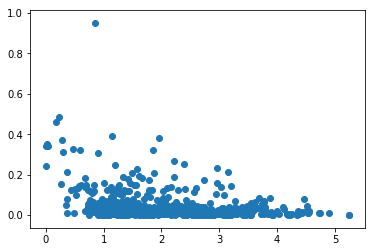

In [211]:
rfFinal = RandomForestRegressor(n_estimators = 300,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.5,
                           max_leaf_nodes=None, bootstrap=True)
trainBG, testBG, trainBGout, testBGout = train_test_split(trainingBG, target['bandgap_energy_ev'])
rfFinal.fit(trainBG, trainBGout)
BGpred = rfFinal.predict(testBG)
seriesError = np.sqrt(np.power((np.log(BGpred+1) - np.log(testBGout+1)),2))
dfPlotError = pd.DataFrame(columns=['BG Error'])
dfPlotError['BG Error'] = seriesError
dfPlotError['Band Gap'] = testBGout
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Band Gap'], dfPlotError['BG Error'])
print(np.argmax(rfFinal.feature_importances_))
print(mean_squared_log_error_JT(BGpred, testBGout))

[  2.73709481e-03   4.25308726e-03   1.24907281e-03   2.66297969e-03
   1.61715356e-03   2.00310247e-03   1.87549924e-04   2.26131924e-03
   1.28352338e-01   1.03900336e-02   1.50943976e-03   2.78296338e-03
   3.04957261e-04   1.84348853e-04   1.19862940e-02   4.49966850e-03
   2.08757279e-03   5.67484970e-03   7.11844117e-03   2.21737176e-03
   1.67728925e-03   3.32522879e-03   3.19986670e-03   1.20604817e-03
   1.81518557e-03   9.26278406e-04   2.64799273e-03   4.30830155e-03
   4.86802504e-04   7.89744079e-03   2.01305139e-03   2.10639031e-03
   5.09550616e-03   5.45728598e-05   3.20333356e-03   1.51726481e-03
   1.82291662e-03   2.34488348e-03   1.60347622e-03   1.82496775e-03
   1.67260346e-03   1.29724903e-01   3.97472261e-03   1.89708081e-03
   4.37994214e-03   2.92750302e-03   1.64175405e-03   1.43971637e-04
   1.04151961e-03   2.63637961e-03   4.59767747e-03   5.79598639e-03
   2.53050000e-03   2.67775947e-03   3.27314043e-03   1.61092440e-03
   4.48399184e-02   4.48275828e-03

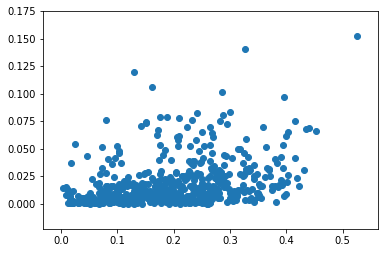

In [214]:
rfFinal = RandomForestRegressor(n_estimators = 10000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.5,
                           max_leaf_nodes=None, bootstrap=True)
trainFE, testFE, trainFEout, testFEout = train_test_split(trainingFE, target['formation_energy_ev_natom'])
rfFinal.fit(trainFE, trainFEout)
FEpred = rfFinal.predict(testFE)
seriesError = np.sqrt(np.power((np.log(FEpred+1) - np.log(testFEout+1)),2))
dfPlotError = pd.DataFrame(columns=['FE Error'])
dfPlotError['FE Error'] = seriesError
dfPlotError['Formation Energy'] = testFEout
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Formation Energy'], dfPlotError['FE Error'])
print(rfFinal.feature_importances_)
print(mean_squared_log_error_JT(FEpred, testFEout))

In [220]:
#--Random Forests: Final fitting and prediction
# RF for BG fitting and prediction
rfBG = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=4,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.1,
                             max_leaf_nodes=None, bootstrap=True)
rfBG.fit(trainStd, target['bandgap_energy_ev'])
predrfBG = rfBG.predict(testStd)

# RF for FE fitting and prediction
rfFE = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.3,
                             max_leaf_nodes=None, bootstrap=True)
rfFE.fit(trainStd, target['formation_energy_ev_natom'])
predrfFE = rfFE.predict(testStd)

In [221]:
#--RF: Create submission and save to csv
dfSubmitRF = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitRF['formation_energy_ev_natom'] = predrfFE
dfSubmitRF['bandgap_energy_ev'] = predrfBG
dfSubmitRF.to_csv('rf_nomad_RF_01132018.csv')